In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!cp "/content/drive/MyDrive/Capstone Project/Machine Learning/train.csv" .
!cp "/content/drive/MyDrive/Capstone Project/Machine Learning/test.csv" .

# Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
import transformers
import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

%matplotlib inline

tqdm.pandas()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset Preprocessing

## Load train and test datasets

In [ ]:
df_train = pd.read_csv('train.csv', index_col=0)
#df_train = pd.read_csv('/content/drive/MyDrive/Data Structure Project/train.csv', index_col=0)
#df_test = pd.read_csv('/content/drive/MyDrive/Data Structure Project/test.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset has attributes such as id, keyword, location, text, and target. We shall only use text and target for our model

In [ ]:
# Select specific columns and discard the rest
df_train = df_train[['text', 'target']]
df_test = df_test[['text']]

# Drop null value rows in place
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

## Distribution of dataset
In order to ensure that the training is good, we must ensure that there are equal amount of examples for each class

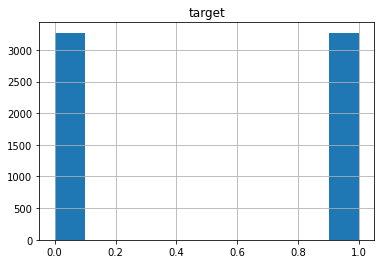

In [ ]:
# Balance the dataset
df_train = df_train.groupby('target')
df_train = pd.DataFrame(df_train.apply(lambda x: x.sample(df_train.size().min())).reset_index(drop=True))

# Plot the distribution according to output labels
df_train.hist()
plt.show()

Final dataset size for training and validation



In [ ]:
df_train.shape

(6542, 2)

## Text Cleaning

Let's print some examples of text present in the dataset

In [ ]:
random_tweets = df_train['text'][np.random.uniform(0, df_train.shape[0], (5,)).astype(int)].values.tolist()
random_tweets

["\x89ÛÓ bulletproof and black like a funeral; the world around us is burning but we're so cold. http://t.co/uqssnAAtTu",
 'How American war planners singled out Hiroshima for destruction http://t.co/B5OKgpSpbH',
 'The Most Generous Bride on Earth: Couple Feeds 4000 Syrian Refugees on Their Wedding Day http://t.co/ms8e8mNddb via @thedailybeast love it!',
 'can still see it...blank expression...cheeks clapping in my face...marvins room playing subtlety in the back yet drowning out all the sound',
 'Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/5qYcZyWKgG']

As we can see, the tweet is not very clean. We need to apply some cleaning operations as follows

- Remove any person or page tagged by the user using @ operator
- Remove any URLs in the tweets
- Remove emojis added by the user
- Remove &amp occurences
- Remove all the non-alphanumeric characters
- Remove all stopwords
- Perform stemming and lemmatization
- Convert the text to lowercase

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))
#stopwords.remove('no')
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_tweet(text):

    # Remove tagged person/page
    text = re.sub('@[A-Za-z0-9]+', '', text)

    # Remove URLS
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Remove emojis
    text = re.sub(r'[\U0001F600-\U0001F64F]+', ' ', text)

    # Remove ampersands
    text = re.sub(r'&amp', ' ', text)

    # Only keep alphabets and spaces
    text = re.sub(r'[^A-Za-z \t\n]+', ' ', text)
    text = text.lower()

    # Remove stopwords
    words = nltk.tokenize.word_tokenize(text)
    words = [word for word in words if not word in stopwords ]
    
    # Perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

for tweet in random_tweets:
    print(clean_tweet(tweet), '\n')

bulletproof black like funeral world around u burning cold 

american war planner singled hiroshima destruction 

generous bride earth couple feed syrian refugee wedding day via love 

still see blank expression cheek clapping face marvins room playing subtlety back yet drowning sound 

christian attacked muslim temple mount waving israeli flag via pamela geller 



In [ ]:
# Now clean all the text in train and test dataframes
df_train['text'] = df_train['text'].progress_apply(lambda x: clean_tweet(x))

  0%|          | 0/6542 [00:00<?, ?it/s]

In [ ]:
df_test['text'] = df_test['text'].progress_apply(lambda x: clean_tweet(x))

  0%|          | 0/3263 [00:00<?, ?it/s]

# Train/test/val set preparation

We will divide the training set into training and validation set

In [ ]:
X = df_train['text'].values
Y = df_train['target'].values
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(f'Shape of X train: {X_train.shape}')
print(f'Shape of Y train: {Y_train.shape}')
print(f'Shape of X val: {X_val.shape}')
print(f'Shape of Y val: {Y_val.shape}')

Shape of X train: (5233,)
Shape of Y train: (5233,)
Shape of X val: (1309,)
Shape of Y val: (1309,)


#Analysis of train/val sets

In [ ]:
text = {
    'train_disaster': [' '.join(tweet.split()) for tweet in X_train[Y_train==1]],
    'train_non_disaster': [' '.join(tweet.split()) for tweet in X_train[Y_train==0]],
    'val_disaster': [' '.join(tweet.split()) for tweet in X_val[Y_val==1]],
    'val_non_disaster': [' '.join(tweet.split()) for tweet in X_val[Y_val==0]]
    }

## Frequency of words in tweets

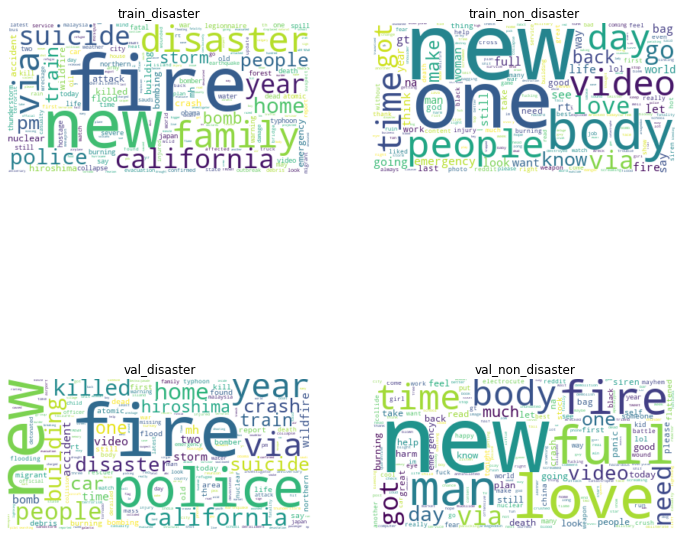

In [ ]:
plt.figure(figsize=(12,12))
for i, (title, v) in enumerate(text.items()):
    v = ' '.join(v)
    plt.subplot(2, 2, i+1)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(v)
    plt.title(title)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
plt.show()

## Average number of characters in a tweet

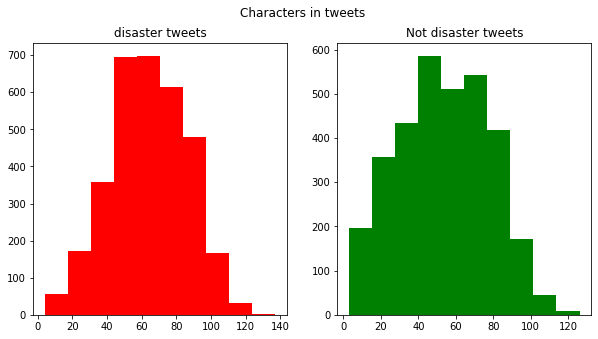

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len=df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')

plt.show()

## Average word length in a tweet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


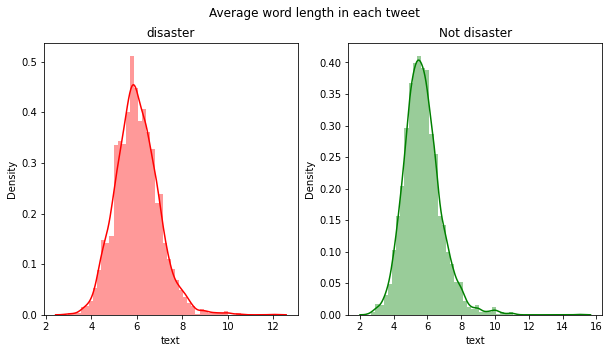

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')

word=df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

plt.show()

# Evaluation metrics definitions

In [ ]:
def evaluate_performance(Y_true, Y_pred):
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1_score = (2*precision*recall)/(precision+recall)
    accuracy = accuracy_score(Y_true, Y_pred)
    print(f'precision: {precision:.2f}')
    print(f'recall: {recall:.2f}')
    print(f'f1_score: {f1_score:.2f}')
    print(f'accuracy: {accuracy:.2f}')
    sns.heatmap(confusion_matrix(Y_true, Y_pred), annot=True, fmt='')
    plt.show()

# CountVectorizer

In [ ]:
vect = CountVectorizer().fit(X_train)

In [ ]:
vect.get_feature_names_out()[::1000]

array(['aa', 'bloom', 'cover', 'esoteric', 'handi', 'kodiak', 'mutant',
       'ppc', 'search', 'target', 'weeklong'], dtype=object)

In [ ]:
print("Total features extracted ", len(vect.get_feature_names_out()))

Total features extracted  10352


In [ ]:
X_train_vectorized = vect.transform(X_train)


# Train the model
model = LogisticRegression()
#model = SGDClassifier(loss = "hinge", penalty = "l1")
model.fit(X_train_vectorized, Y_train)

LogisticRegression()

Performance of Count Vectorizer
precision: 0.84
recall: 0.75
f1_score: 0.79
accuracy: 0.80


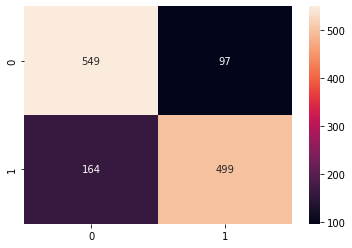

In [ ]:
Y_pred = model.predict(vect.transform(X_val))
print('Performance of Count Vectorizer')
evaluate_performance(Y_val, Y_pred)

# TFIFD

In [ ]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
len(vect.get_feature_names_out())

1889

In [ ]:
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
#model = SGDClassifier(loss = "hinge", penalty = "l1")
model.fit(X_train_vectorized, Y_train)

Y_pred = model.predict(vect.transform(X_val))

In [ ]:
feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf in our document:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf in our document: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf in our document:
['sh' 'marians' 'declaration' 'fog' 'curved' 'prebreak' 'disea' 'quran'
 'prophetmuhammad' 'madinah']

Largest tfidf in our document: 
['riot' 'fire' 'tweet' 'save' 'flooding' 'flattened' 'burned' 'flame'
 'scream' 'screamed']


In [ ]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs in our document:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs in our document: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs in our document:
['new' 'bag' 'love' 'let' 'full' 'ruin' 'blew' 'screaming' 'song' 'want']

Largest Coefs in our document: 
['hiroshima' 'fire' 'bombing' 'wildfire' 'train' 'flood' 'california'
 'storm' 'typhoon' 'japan']


Performance of TFIDF
precision: 0.83
recall: 0.77
f1_score: 0.80
accuracy: 0.80


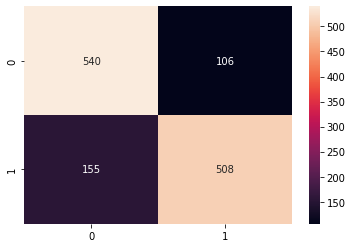

In [ ]:
print('Performance of TFIDF')
evaluate_performance(Y_val, Y_pred)

# nGrams

In [ ]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names_out())

2519

In [ ]:
model = LogisticRegression()
#model = SGDClassifier(loss = "hinge", penalty = "l1")
model.fit(X_train_vectorized, Y_train)

Y_pred = model.predict(vect.transform(X_val))

In [ ]:
feature_names = np.array(vect.get_feature_names_out())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs in our document :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs in our document : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs in our document :
['ticket' 'super' 'better' 'ice' 'word' 'republican' 'cake' 'august'
 'mode' 'bag']

Largest Coefs in our document : 
['hiroshima' 'wildfire' 'derailment' 'bombing' 'typhoon' 'earthquake'
 'rioting' 'hailstorm' 'storm' 'flood']


Performance of n_grams
precision: 0.82
recall: 0.75
f1_score: 0.79
accuracy: 0.79


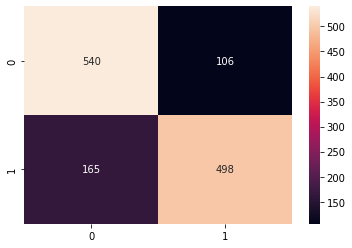

In [ ]:
print('Performance of n_grams')
evaluate_performance(Y_val, Y_pred)

# Transformers

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

In [ ]:
# Tokenize
def tokenize(tokenizer, data):
  input_ids = list()
  attention_masks = list()
  for text in tqdm(data):
    processed_text = tokenizer(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_attention_mask=True)
    input_ids.append(processed_text['input_ids'])
    attention_masks.append(processed_text['attention_mask'])
  return np.array(input_ids).astype('int32'), np.array(attention_masks).astype('int32')

X_train_ids, X_train_masks = tokenize(tokenizer, X_train)
X_val_ids, X_val_masks = tokenize(tokenizer, X_val)

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

In [98]:
# Build model
x_ids = tf.keras.layers.Input(128, dtype='int32')
x_masks = tf.keras.layers.Input(128, dtype='int32')
y = transformers.TFAlbertModel.from_pretrained('albert-base-v2')([x_ids, x_masks])
y_a = y[1]
y_b = y[0]
y_b = tf.squeeze(y_b[:, -1:, :], axis=1)
y = tf.keras.layers.Concatenate()([y_a, y_b])
y = tf.keras.layers.Dense(32, activation='relu')(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(1, activation='sigmoid')(y)
model = tf.keras.models.Model(inputs=[x_ids, x_masks], outputs=y)
model.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(name='precision'),
                                                                                             tf.keras.metrics.Recall(name='recall'), 'accuracy'])
model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_albert_model_4 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_9[0][0]',                
 el)                            thPooling(last_hidd               'input_10[0][0]']               
                                en_state=(None, 128                                               
                                , 768),                                                     

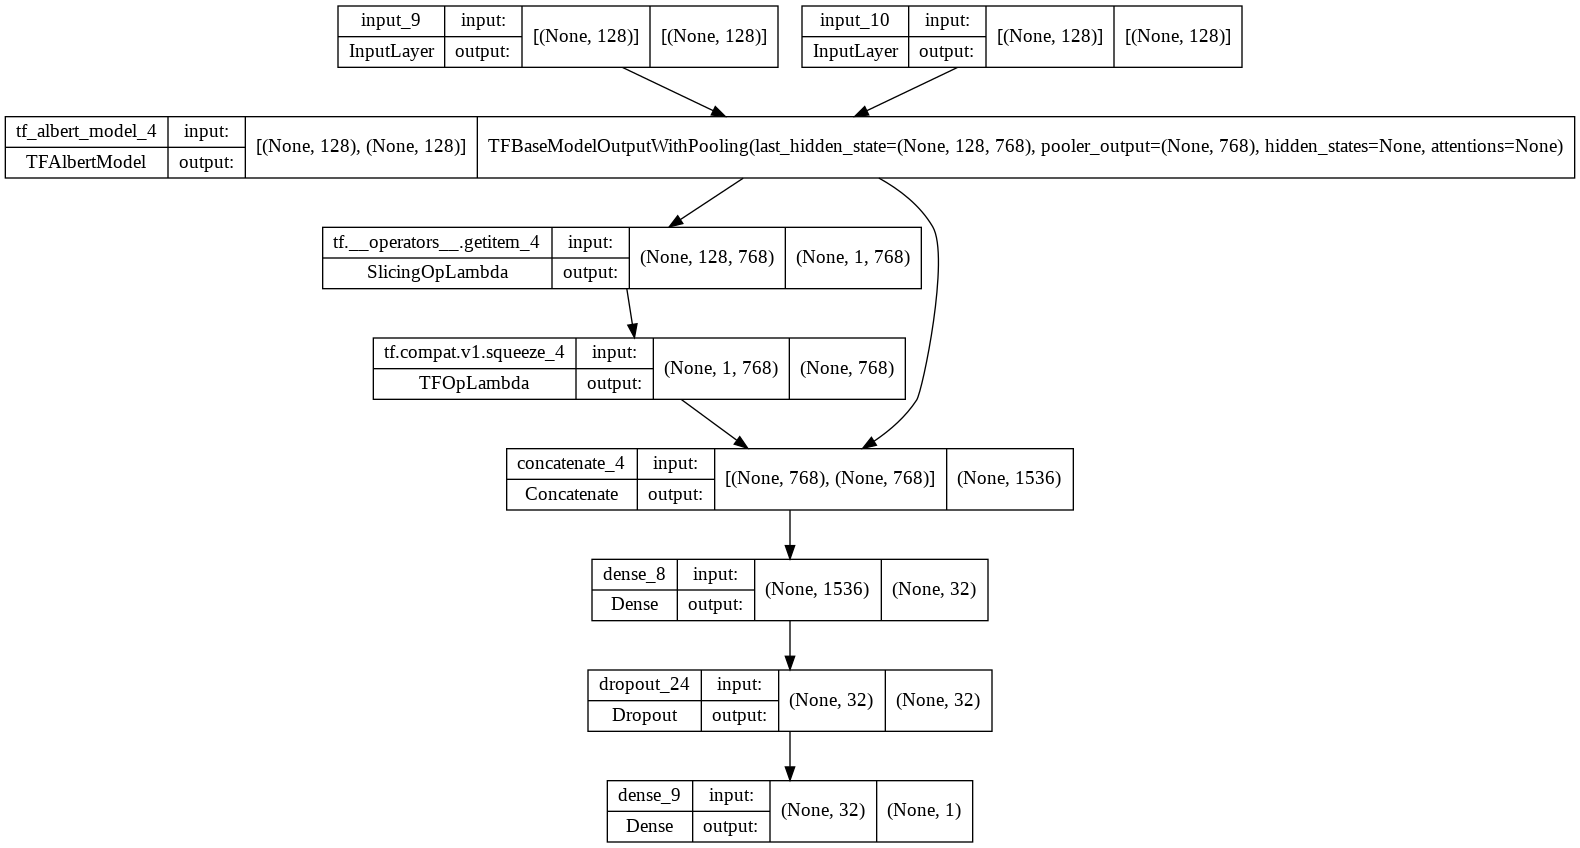

In [102]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [100]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Capstone Project/Machine Learning/weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(verbose=1, min_lr=1e-7, patience=2),
             tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
]

In [101]:
# Model training and evaluation
model.fit([X_train_ids, X_train_masks], Y_train, validation_data=([X_val_ids, X_val_masks], Y_val), epochs=10, batch_size=32, verbose=1, callbacks=callbacks)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 0.5198 - precision: 0.7921 - recall: 0.7055 - accuracy: 0.7609
Epoch 1: val_loss improved from inf to 0.45852, saving model to /content/drive/MyDrive/Capstone Project/Machine Learning/weights.h5
164/164 [==============================] - 280s 2s/step - loss: 0.5198 - precision: 0.7921 - recall: 0.7055 - accuracy: 0.7609 - val_loss: 0.4585 - val_precision: 0.8780 - val_recall: 0.6621 - val_accuracy: 0.7823 - lr: 2.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 0.4277 - precision: 0.8603 - recall: 0.7554 - accuracy: 0.8169
Epoch 2: val_loss improved from 0.45852 to 0.45445, saving model to /content/drive/MyDrive/Capstone Project/Machine Learning/weights.h5
164/164 [==============================] - 257s 2s/step - loss: 0.4277 - precision: 0.8603 - recall: 0.7554 - accuracy: 0.8169 - val_loss: 0.4545 - val_precision: 0.9083 - val_recall: 0.6576 - val_accuracy: 0.7930 - lr: 2.0000e-05
Epoc

In [103]:
model.load_weights('/content/drive/MyDrive/Capstone Project/Machine Learning/weights.h5')

In [104]:
Y_pred = model.predict([X_val_ids, X_val_masks])

Performance of ALBERT model
precision: 0.85
recall: 0.78
f1_score: 0.81
accuracy: 0.82


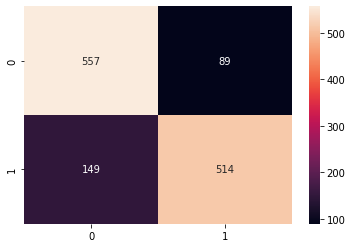

In [108]:
Y_pred_2 = ((Y_pred >= 0.5)+0).reshape(-1)
print('Performance of ALBERT model')
evaluate_performance(Y_val, Y_pred_2)